In [1]:
#참고 자료 - https://eeqmeung.tistory.com/2

import pandas as pd
import numpy as np
np.random.seed(111)

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2015, 12, 30)
end = datetime.datetime(2022, 2, 18)

# 야후 API에서 코스피 지수를 pandas 데이터프레임으로 가져오기
# code_name = '^KS11'
code_name = '008770.KS'   # 호텔신라 - 계절/시즌의 성격을 나타낼 수 있지 않을까? (220219)

data = web.DataReader(code_name, "yahoo", start, end)
data.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-02-14,79600.0,77300.0,77400.0,78800.0,381069.0,78800.0
2022-02-15,79400.0,77100.0,78700.0,78300.0,312626.0,78300.0
2022-02-16,80900.0,79000.0,79500.0,80600.0,558973.0,80600.0
2022-02-17,82000.0,78500.0,80500.0,80400.0,804841.0,80400.0
2022-02-18,81000.0,79400.0,79400.0,80400.0,295751.0,80400.0


In [2]:
# 데이터의 갯수가 5로 나누어 떨어져야 한다. (220219)
# 1주일치 (5일) 데이터를 예측하기 위해서.

# 5로 나누어 떨어지지 않는 경우, 시작 날짜를 조정한다.
print(len(data))

1505


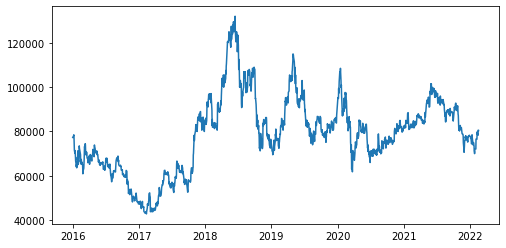

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 4))
plt.plot(data['Close'])    # 종가(Close) 데이터 그래프로 확인
plt.show()

In [4]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-30,79600.0,77000.0,79600.0,77300.0,530967.0,75324.093750
2016-01-04,79300.0,77400.0,77800.0,78100.0,287659.0,76103.640625
2016-01-05,78900.0,77400.0,78300.0,78500.0,236187.0,76493.421875
2016-01-06,79100.0,76500.0,78900.0,77300.0,370562.0,75324.093750
2016-01-07,78300.0,73200.0,77300.0,73500.0,856384.0,71621.226562


In [5]:
from sklearn.preprocessing import MinMaxScaler
# 데이터 정규화 : 모든 종가 데이터를 0-1사의 값으로 비율로 저장

scalar = MinMaxScaler(feature_range=(0, 1))

data_val = data.filter(['Close']).values 
scaled_data = scalar.fit_transform(data_val)

print(scaled_data)
print(len(scaled_data))

[[0.3867713 ]
 [0.39573991]
 [0.40022422]
 ...
 [0.42376682]
 [0.42152466]
 [0.42152466]]
1505


In [6]:
# train data length
import math
training_data_len = math.ceil(len(scaled_data)*0.9)

print(training_data_len)
print(1505*0.9)                 # 결과 확인 : 데이터의 90%

# 중요 : trainig_data_len이 5로 나누어 떨어지지 않으면 학습이 진행되지 않는다.
# (220219)

1355
1354.5


In [7]:
# set train data
train_data = scaled_data[0:training_data_len]
print("train data :", train_data)

train data : [[0.3867713 ]
 [0.39573991]
 [0.40022422]
 ...
 [0.60986547]
 [0.57286996]
 [0.56053812]]


In [8]:
# Append Past_SET to x_train

x_train = []
y_train = []

print(type(x_train))

<class 'list'>


In [9]:
# 훈련 데이터는 전체 중 0.8의 비중으로 한다.
# 아래 for루프는 LSTM에서 요구하는대로 formatting

# PAST_SET은 예측 날짜로부터 기억할 전날의 크기
# 예를들어, 30은 예측일로부터 30일 전까지의 데이터까지 모두 예측하는데 고려할 날
# --> LSTM의 '기억'이 30일

# PAST_SET = 300  # 계절성을 고려하여 약 1년 분량을 기억한다면? (220219)
PAST_SET = 10

In [10]:
# for i in range(PAST_SET, len(train_data)):
for i in range(PAST_SET, len(train_data), 5):    # 1주일(5일치 예측)
    x_train.append(train_data[i-PAST_SET:i, 0])
    y_train.append(train_data[i:i+5, 0])


print(type(x_train))

x_train, y_train = np.array(x_train), np.array(y_train)  

print(type(x_train))
print(np.shape(x_train))
print(np.shape(y_train))

<class 'list'>
<class 'numpy.ndarray'>
(269, 10)
(269, 5)


In [11]:
print(x_train)
print(np.shape(x_train))
print(len(x_train))

[[0.3867713  0.39573991 0.40022422 ... 0.3206278  0.31053812 0.28587444]
 [0.32286996 0.30605381 0.3206278  ... 0.23766816 0.25       0.23318386]
 [0.26793722 0.24887892 0.23766816 ... 0.2735426  0.2970852  0.31950673]
 ...
 [0.60426009 0.61098655 0.6132287  ... 0.62668161 0.61883408 0.63452915]
 [0.62668161 0.62780269 0.62668161 ... 0.61210762 0.5896861  0.5941704 ]
 [0.62107623 0.59080717 0.61210762 ... 0.61098655 0.60762332 0.59529148]]
(269, 10)
269


In [12]:
print(y_train)
print(len(y_train))

[[0.26793722 0.24887892 0.23766816 0.25       0.23318386]
 [0.24887892 0.28811659 0.2735426  0.2970852  0.31950673]
 [0.25       0.26793722 0.26681614 0.29147982 0.3441704 ]
 ...
 [0.62107623 0.59080717 0.61210762 0.5896861  0.5941704 ]
 [0.62331839 0.6132287  0.61098655 0.60762332 0.59529148]
 [0.59641256 0.59304933 0.60986547 0.57286996 0.56053812]]
269


In [13]:
# LSTM needs to get 3rd shape

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_train shape : ", np.shape(x_train))

# 훈련 데이터 셋의 차원 크기 : 2152개의 데이터가 각각 30일 전까지 포함, 뒤 1은 LSTM에서 요구하는 형태이다.

x_train shape :  (269, 10, 1)


In [14]:
x_train

array([[[0.3867713 ],
        [0.39573991],
        [0.40022422],
        ...,
        [0.3206278 ],
        [0.31053812],
        [0.28587444]],

       [[0.32286996],
        [0.30605381],
        [0.3206278 ],
        ...,
        [0.23766816],
        [0.25      ],
        [0.23318386]],

       [[0.26793722],
        [0.24887892],
        [0.23766816],
        ...,
        [0.2735426 ],
        [0.2970852 ],
        [0.31950673]],

       ...,

       [[0.60426009],
        [0.61098655],
        [0.6132287 ],
        ...,
        [0.62668161],
        [0.61883408],
        [0.63452915]],

       [[0.62668161],
        [0.62780269],
        [0.62668161],
        ...,
        [0.61210762],
        [0.5896861 ],
        [0.5941704 ]],

       [[0.62107623],
        [0.59080717],
        [0.61210762],
        ...,
        [0.61098655],
        [0.60762332],
        [0.59529148]]])

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1)) 
model.add(Dense(10, activation='relu'))
# 가중치에 음수가 있으므로 활성화 함수 종류는 큰 차이 없다
model.add(Dropout(0.1))
model.add(Dense(5, activation='sigmoid'))    
# 최종 5개의 다음 값을 예측한다.

# model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss='mae')



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5

In [16]:
# Train
model.fit(x_train, y_train, batch_size=5, epochs=200)
# 배치 사이즈 및 에포크 변경하면서 학습 결과 모니터링(210224)

Epoch 1/200
54/54 [==============================] - 0s 1ms/step - loss: 0.1722
Epoch 2/200
54/54 [==============================] - 0s 983us/step - loss: 0.1213
Epoch 3/200
54/54 [==============================] - 0s 996us/step - loss: 0.1055
Epoch 4/200
54/54 [==============================] - 0s 987us/step - loss: 0.0955
Epoch 5/200
54/54 [==============================] - 0s 1ms/step - loss: 0.0867
Epoch 6/200
54/54 [==============================] - 0s 982us/step - loss: 0.0890
Epoch 7/200
54/54 [==============================] - 0s 1ms/step - loss: 0.0902
Epoch 8/200
54/54 [==============================] - 0s 1ms/step - loss: 0.1047
Epoch 9/200
54/54 [==============================] - 0s 1ms/step - loss: 0.0862
Epoch 10/200
54/54 [==============================] - 0s 1ms/step - loss: 0.0888
Epoch 11/200
54/54 [==============================] - 0s 1ms/step - loss: 0.0880
Epoch 12/200
54/54 [==============================] - 0s 960us/step - loss: 0.0839
Epoch 13/200
54/54 [=======

54/54 [==============================] - 0s 977us/step - loss: 0.0458
Epoch 200/200
54/54 [==============================] - 0s 1ms/step - loss: 0.0505


In [17]:
test_data = scaled_data[(training_data_len - PAST_SET):, :]

x_test = []
y_test = scaled_data[training_data_len:, :]

print(y_test)
print(test_data)
print(len(test_data))
print(len(y_test))

[[0.55941704]
 [0.5661435 ]
 [0.58856502]
 [0.56950673]
 [0.57847534]
 [0.58520179]
 [0.56726457]
 [0.56053812]
 [0.55044843]
 [0.59641256]
 [0.57735426]
 [0.56502242]
 [0.5706278 ]
 [0.56950673]
 [0.57847534]
 [0.56838565]
 [0.55717489]
 [0.55829596]
 [0.57511211]
 [0.57286996]
 [0.57847534]
 [0.56278027]
 [0.55381166]
 [0.55156951]
 [0.55381166]
 [0.52914798]
 [0.49439462]
 [0.51233184]
 [0.46860987]
 [0.46524664]
 [0.47085202]
 [0.51345291]
 [0.50896861]
 [0.52017937]
 [0.5190583 ]
 [0.5190583 ]
 [0.52690583]
 [0.51681614]
 [0.51681614]
 [0.52017937]
 [0.52130045]
 [0.52802691]
 [0.52130045]
 [0.50224215]
 [0.51008969]
 [0.4955157 ]
 [0.53363229]
 [0.52690583]
 [0.51457399]
 [0.5190583 ]
 [0.51233184]
 [0.51681614]
 [0.51345291]
 [0.50336323]
 [0.48991031]
 [0.49103139]
 [0.46973094]
 [0.51121076]
 [0.52017937]
 [0.54035874]
 [0.53699552]
 [0.52578475]
 [0.55493274]
 [0.55717489]
 [0.56053812]
 [0.5470852 ]
 [0.54035874]
 [0.52914798]
 [0.52690583]
 [0.52242152]
 [0.5470852 ]
 [0.54

In [18]:
# for i in range(PAST_SET, len(test_data)):
for i in range(PAST_SET, len(test_data), 5):
    x_test.append(test_data[i - PAST_SET:i, 0])

In [19]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

In [20]:
# un scaling
predictions = scalar.inverse_transform(predictions)

In [21]:
print(predictions.shape)

(30, 5)


In [22]:
predictions

array([[92918.61 , 92155.086, 92307.32 , 91539.15 , 92068.13 ],
       [94077.45 , 93235.5  , 93380.195, 92511.83 , 93091.38 ],
       [94602.44 , 93725.48 , 93866.71 , 92953.36 , 93555.59 ],
       [94263.48 , 93409.08 , 93552.555, 92668.2  , 93255.82 ],
       [94192.02 , 93342.4  , 93486.34 , 92608.125, 93192.64 ],
       [92474.73 , 91741.63 , 91896.72 , 91167.24 , 91676.664],
       [83369.27 , 83501.4  , 83597.42 , 83660.875, 83672.33 ],
       [89108.76 , 88620.73 , 88765.09 , 88353.93 , 88712.64 ],
       [89165.35 , 88687.37 , 88819.53 , 88407.16 , 88763.26 ],
       [87060.06 , 86792.805, 86891.59 , 86657.06 , 86928.555],
       [88681.01 , 88250.39 , 88380.96 , 88008.336, 88338.42 ],
       [85187.2  , 85107.336, 85185.375, 85108.664, 85291.72 ],
       [90376.77 , 89789.94 , 89958.164, 89413.45 , 89829.28 ],
       [92879.414, 92118.57 , 92271.06 , 91506.305, 92033.56 ],
       [89752.84 , 89229.45 , 89365.11 , 88898.1  , 89281.08 ],
       [86251.85 , 86071.805, 86149.54 ,

In [23]:
predictions.shape = predictions.shape[0]*predictions.shape[1]

In [24]:
predictions

array([92918.61 , 92155.086, 92307.32 , 91539.15 , 92068.13 , 94077.45 ,
       93235.5  , 93380.195, 92511.83 , 93091.38 , 94602.44 , 93725.48 ,
       93866.71 , 92953.36 , 93555.59 , 94263.48 , 93409.08 , 93552.555,
       92668.2  , 93255.82 , 94192.02 , 93342.4  , 93486.34 , 92608.125,
       93192.64 , 92474.73 , 91741.63 , 91896.72 , 91167.24 , 91676.664,
       83369.27 , 83501.4  , 83597.42 , 83660.875, 83672.33 , 89108.76 ,
       88620.73 , 88765.09 , 88353.93 , 88712.64 , 89165.35 , 88687.37 ,
       88819.53 , 88407.16 , 88763.26 , 87060.06 , 86792.805, 86891.59 ,
       86657.06 , 86928.555, 88681.01 , 88250.39 , 88380.96 , 88008.336,
       88338.42 , 85187.2  , 85107.336, 85185.375, 85108.664, 85291.72 ,
       90376.77 , 89789.94 , 89958.164, 89413.45 , 89829.28 , 92879.414,
       92118.57 , 92271.06 , 91506.305, 92033.56 , 89752.84 , 89229.45 ,
       89365.11 , 88898.1  , 89281.08 , 86251.85 , 86071.805, 86149.54 ,
       85986.83 , 86225.59 , 81182.72 , 81348.7  , 

In [25]:
print(y_test.shape)

(150, 1)


In [26]:
# rmse = np.sqrt(np.mean(predictions - y_test)**2)
# print("rmse : ", rmse)

# 평균 제곱 오차 계산 : 값의 크기에 따라 예측 결과 평가

In [27]:
# 다음주 예측 더미 구간 만들기 (220219)

from datetime import datetime
import numpy as np
import pandas as pd

add_pred_date = [datetime(2022,2,21), datetime(2022,2,22), datetime(2022,2,23), datetime(2022,2,24), datetime(2022,2,25)]
add_dummy_data = [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]
add_predict_date = pd.DataFrame(add_dummy_data, add_pred_date, columns = ['a'])
add_predict_date

,a
2022-02-21,NaN
2022-02-22,NaN
2022-02-23,NaN
2022-02-24,NaN
2022-02-25,NaN


In [28]:
valid = pd.concat([data, add_predict_date], axis = 0, ignore_index=False)  # 0 행 방향 연결
valid = valid[training_data_len+5:len(valid)] 
# 예측 구간만 잘라서 정리 150일 분량 (220219)
valid.head()

,High,Low,Open,Close,Volume,Adj Close,a
2021-07-16,95100.0,93800.0,94000.0,95000.0,200894.0,94757.039062,NaN
2021-07-19,94700.0,93200.0,93800.0,93400.0,324772.0,93161.125000,NaN
2021-07-20,93300.0,92100.0,92200.0,92800.0,225549.0,92562.664062,NaN
2021-07-21,93400.0,91600.0,93400.0,91900.0,274610.0,91664.960938,NaN
2021-07-22,97200.0,93500.0,93500.0,96000.0,1129634.0,95754.476562,NaN


In [29]:
valid.drop(['a'], axis=1)
valid.tail()

,High,Low,Open,Close,Volume,Adj Close,a
2022-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
valid['Predictions'] = predictions
valid.tail()

,High,Low,Open,Close,Volume,Adj Close,a,Predictions
2022-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79768.101562
2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79997.523438
2022-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80377.765625
2022-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80487.773438
2022-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79999.437500


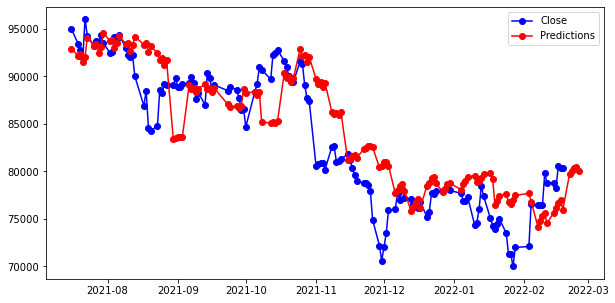

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(valid['Close'], '-bo')
plt.plot(valid['Predictions'], '-ro')
plt.legend(['Close', 'Predictions'])
plt.show()

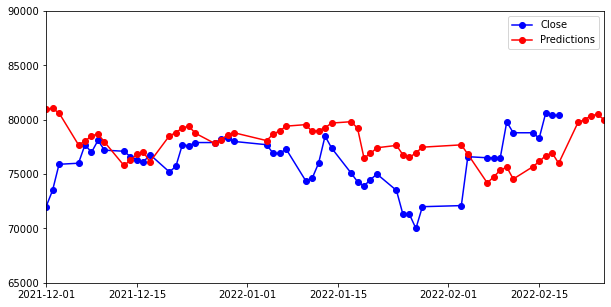

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(valid['Close'], '-bo')
plt.plot(valid['Predictions'], '-ro')
plt.legend(['Close', 'Predictions'])

x_min = datetime(2021, 12, 1)
x_max = datetime(2022, 2, 25)
plt.xlim(x_min, x_max)
plt.ylim(65000, 90000)

plt.show()

In [33]:
# 마지막 5개의 데이터는 다음주 예측값 5개를 나타낸다. (2/21(월)~25(금))
# LSTM을 이용한 주가 예측의 한계 : 예측이 아닌, time shift 결과로 나타난다. (220220)